# Evaluation for Pycox model

In this notebook we introduce the use of `PycoxEvaluator` in the package through an example dataset and a model.
The first half of this notebook follows the procedure described in the Pycox [example](https://github.com/havakv/pycox/blob/master/examples/01_introduction.ipynb).

In the following we will:

1. Load the METABRIC survival dataset and create a `LogisticHazard` model;
2. Train the model using training set;
3. Evaluate the performance using the concordance index, Brier score, Integrated Brier score, L1 loss, 1-calibration, and D-calibration.

In [ ]:
!pip install pycox
!pip install sklearn-pandas
!pip install torchtuples

## Import Dependencies
Note: You need `sklearn-pandas` for normalizing the data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import LogisticHazard

from SurvivalEVAL import PycoxEvaluator

In [3]:
%matplotlib inline

## Load Dataset
Set seed for torch and numpy for reproducibility

In [4]:
np.random.seed(1234)
_ = torch.manual_seed(123)

Load the dataset, split it into training (64%), validation (16%) and testing set (20%).
Then standardize the covariates.

In [5]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Build the model and train it.

In [6]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)
durations_train, events_train = get_target(df_train)

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

/home/shiang/anaconda3/envs/SurvEVAL/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


0:	[0s / 0s],		train_loss: 2.9263,	val_loss: 2.7659
1:	[0s / 0s],		train_loss: 2.6603,	val_loss: 2.5461
2:	[0s / 0s],		train_loss: 2.3791,	val_loss: 2.2354
3:	[0s / 0s],		train_loss: 2.0756,	val_loss: 1.9005
4:	[0s / 0s],		train_loss: 1.7898,	val_loss: 1.5965
5:	[0s / 0s],		train_loss: 1.5691,	val_loss: 1.4399
6:	[0s / 0s],		train_loss: 1.4533,	val_loss: 1.3834
7:	[0s / 0s],		train_loss: 1.4080,	val_loss: 1.3732
8:	[0s / 0s],		train_loss: 1.3977,	val_loss: 1.3749
9:	[0s / 0s],		train_loss: 1.3683,	val_loss: 1.3710
10:	[0s / 0s],		train_loss: 1.3406,	val_loss: 1.3672
11:	[0s / 0s],		train_loss: 1.3476,	val_loss: 1.3632
12:	[0s / 0s],		train_loss: 1.3404,	val_loss: 1.3599
13:	[0s / 0s],		train_loss: 1.3284,	val_loss: 1.3536
14:	[0s / 0s],		train_loss: 1.3253,	val_loss: 1.3544
15:	[0s / 0s],		train_loss: 1.3170,	val_loss: 1.3566
16:	[0s / 0s],		train_loss: 1.3101,	val_loss: 1.3618
17:	[0s / 0s],		train_loss: 1.3191,	val_loss: 1.3643
18:	[0s / 0s],		train_loss: 1.2992,	val_loss: 1.3638
19:

/home/shiang/anaconda3/envs/SurvEVAL/lib/python3.11/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(

## Make the prediction.
`surv` is a Dataframe object. Row index represents the time coordinates, and each column represents a survival curve of one patient.

In [7]:
surv = model.interpolate(10).predict_surv_df(x_test)
surv.head(20)

,0,1,2,3,4,5,6,7,8,9,...,371,372,373,374,375,376,377,378,379,380
0.000000,0.993047,0.996519,0.979841,0.994583,0.997945,0.994696,0.998212,0.998118,0.998652,0.997525,...,0.996131,0.994828,0.994968,0.997436,0.995227,0.995589,0.997314,0.998562,0.988151,0.995715
3.946667,0.980414,0.967115,0.969238,0.985821,0.980633,0.988882,0.996073,0.996754,0.975153,0.949467,...,0.985843,0.968926,0.984651,0.995072,0.986154,0.985549,0.987054,0.974574,0.952083,0.977953
7.893333,0.967781,0.937710,0.958635,0.977059,0.963321,0.983068,0.993933,0.995391,0.951655,0.901408,...,0.975555,0.943025,0.974333,0.992708,0.977082,0.975509,0.976794,0.950587,0.916014,0.960190
11.840000,0.955148,0.908305,0.948032,0.968297,0.946008,0.977254,0.991794,0.994028,0.928156,0.853350,...,0.965267,0.917123,0.964016,0.990344,0.968010,0.965469,0.966534,0.926599,0.879946,0.942428
15.786667,0.942514,0.878900,0.937429,0.959535,0.928696,0.971440,0.989654,0.992664,0.904657,0.805291,...,0.954979,0.891222,0.953699,0.987980,0.958938,0.955430,0.956274,0.902612,0.843878,0.924666
19.733334,0.929881,0.849495,0.926826,0.950773,0.911384,0.965626,0.987515,0.991301,0.881159,0.757233,...,0.944691,0.865320,0.943382,0.985616,0.949866,0.945390,0.946014,0.878624,0.807809,0.906904
23.680000,0.917248,0.820090,0.916223,0.942011,0.894072,0.959812,0.985375,0.989938,0.857660,0.709175,...,0.934403,0.839419,0.933064,0.983252,0.940793,0.935350,0.935754,0.854637,0.771741,0.889141
27.626667,0.904615,0.790686,0.905620,0.933249,0.876760,0.953998,0.983236,0.988574,0.834161,0.661116,...,0.924115,0.813517,0.922747,0.980888,0.931721,0.925310,0.925493,0.830649,0.735672,0.871379
31.573334,0.891981,0.761281,0.895018,0.924487,0.859448,0.948184,0.981097,0.987211,0.810662,0.613058,...,0.913827,0.787615,0.912430,0.978524,0.922649,0.915270,0.915233,0.806662,0.699604,0.853617
35.520000,0.879348,0.731876,0.884415,0.915725,0.842136,0.942370,0.978957,0.985848,0.787164,0.565000,...,0.903539,0.761714,0.902112,0.976160,0.913577,0.905230,0.904974,0.782674,0.663535,0.835855


## Build the evaluator.
Some arguments includes:
1. Training set information (`durations_train` and `events_train`) is optional if you don't need Brier score, integrated Brier score, and L1-margin loss.
2. `predicted_time_method` argument indicates whether using median or mean survival time as the predicted time.

In [8]:
eval = PycoxEvaluator(surv, durations_test, events_test, durations_train, events_train, predict_time_method="Median")

## Make some example plots
Plot the survival curves for subject 1, 10 and 100.

In [9]:
eval.plot_survival_curves([1, 10, 100])

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Survival probability'>)

## Calculate the concordance index.
`ties` argument indicates the way ties should be handled.
`ties="None"` will throw out all ties in true survival time and all ties in predict survival times (risk scores).
`ties="Time"` includes ties in true survival time but removes ties in predict survival times (risk scores).
`ties="Risk"` includes ties in predict survival times (risk scores) but not in true survival time.
`ties="All"` includes all ties.

In [10]:
cindex, concordant_pairs, total_pairs = eval.concordance(ties="None")
print("Concordance index is {}, meaning that the model can correctly order {} pairs among {} comparable pairs "
      "in the testing set.".format(cindex, concordant_pairs, total_pairs))

Concordance index is 0.6425452541438806, meaning that the model can correctly order 30314.0 pairs among 47178.0 comparable pairs in the testing set.


## Calculate the Brier score
Target time is at time 175.

In [11]:
bs = eval.brier_score(target_time=175)
print("Brier score at time 175 is {}.".format(bs))

Brier score at time 175 is 0.21308365882553013.


## Calculate the integrated Brier score (IBS)
- You can specify the number of points `num_points` to integral. If it is not specify, the default setting will use the censored time points obtained from testing set.
- You can also set the `IPCW_weighted` as True or False to calculate the IPCW-weighted IBS or non-weighted IBS. The default setting is True.

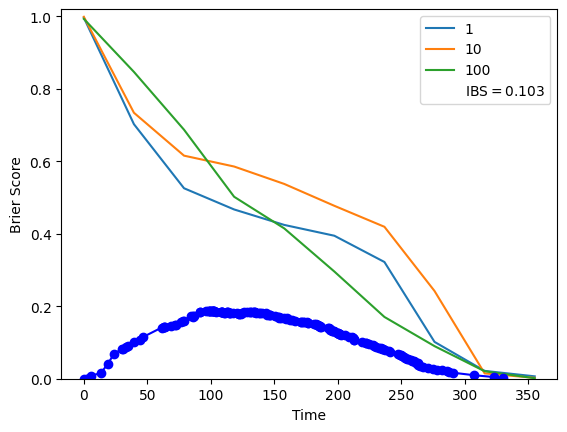

Integrated Brier score is 0.10328325101172314.


In [12]:
ibs = eval.integrated_brier_score(num_points=None, IPCW_weighted=False, draw_figure=True)
print("Integrated Brier score is {}.".format(ibs))

# Calculate the MAE-Hinge loss
You can set `method` as `Hinge`, `Uncensored`, `Margin`, `IPCW-T`, `IPCW-D`, or `Pseudo_obs` for different MAE calculation.

In [13]:
mae_score = eval.mae(method='Hinge')
print("MAE-hinge loss is {}.".format(mae_score))

MAE-hinge loss is 52.07028398412763.


## Calculate the 1-Calibration
Run one calibration test at 50% time of the testing set.

In [14]:
t_time = round(np.percentile(durations_test, 50))
p_value, ob, exp = eval.one_calibration(target_time=t_time, method="DN")
if p_value >= 0.05:
    print("The model is one-calibrated at time {}.".format(t_time))
else:
    print("The model is not one-calibrated at time {}.".format(t_time))

The model is one-calibrated at time 113.


###  Plot the histogram for 1-Calibration.
As presented in [Effective Ways to Build and Evaluate Individual Survival Distributions](https://jmlr.csail.mit.edu/papers/v21/18-772.html)

In [15]:
# Reverse the bins to let it start from small to large observations
ob.reverse()
exp.reverse()

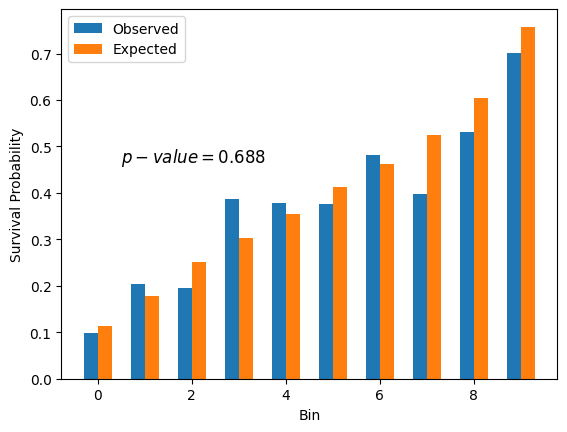

In [16]:
bins = np.arange(10)
plt.bar(bins - 0.15, ob, width=0.3, label="Observed")
plt.bar(bins + 0.15, exp, width=0.3, label="Expected")

plt.xlabel('Bin')
plt.ylabel('Survival Probability')
plt.text(0.5, 0.5, r'$p-value = {:.3f}$'.format(p_value), verticalalignment='top', horizontalalignment='left', fontsize=12, color='Black')
plt.legend()
plt.show()

## Calculate the distribution calibration (D-Calibration)

In [17]:
p_value_2, bin_statistics = eval.d_calibration()
if p_value_2 >= 0.05:
    print("The model is d-calibrated!")
else:
    print("The model is not d-calibrated!")

The model is d-calibrated!


In [18]:
# An ideal model should have bin statistics equally distributed. That means 0.1 for each value since we are using 10 bins.
bin_statistics /= bin_statistics.sum()
bin_statistics

array([0.08710565, 0.12430747, 0.07196516, 0.09830726, 0.09176001,
       0.08667125, 0.09758414, 0.09892774, 0.11810983, 0.12526149])

### Plot the sideways histogram of D-Calibration
As presented in [Effective Ways to Build and Evaluate Individual Survival Distributions](https://jmlr.csail.mit.edu/papers/v21/18-772.html)

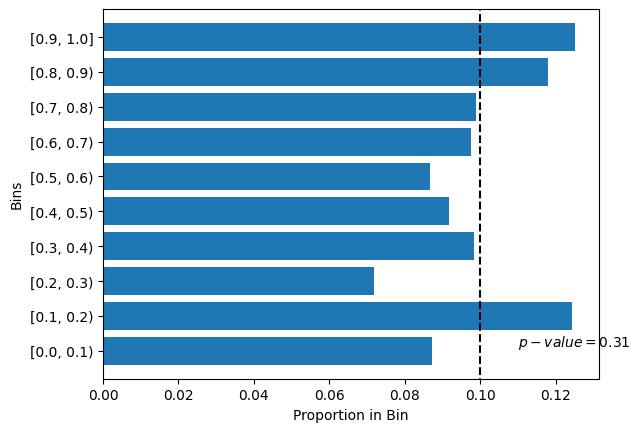

In [19]:
bars = ('[0.0, 0.1)', '[0.1, 0.2)', '[0.2, 0.3)', '[0.3, 0.4)', '[0.4, 0.5)',
        '[0.5, 0.6)', '[0.6, 0.7)', '[0.7, 0.8)', '[0.8, 0.9)', '[0.9, 1.0]')
y_pos = np.arange(len(bars))

fig, ax = plt.subplots()
ax.barh(y_pos, bin_statistics)
ax.plot(np.ones(len(bars)+2) * 0.1, np.arange(-1, len(bars)+1),  '--', color="black")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Proportion in Bin')
ax.set_ylabel('Bins')
ax.text(0.14, 0.5, r'$p-value = {:.2f}$'.format(p_value_2), verticalalignment='top', horizontalalignment='right', fontsize=10, color='Black')
plt.ylim([-0.8, 9.8])
plt.yticks(y_pos, bars)
plt.show()

### Plot the Q-Q plot of D-Calibration
As presented in [Countdown Regression: Sharp and Calibrated Survival Predictions](https://proceedings.mlr.press/v115/avati20a.html) and [Inverse-Weighted Survival Games](https://arxiv.org/abs/2111.08175)

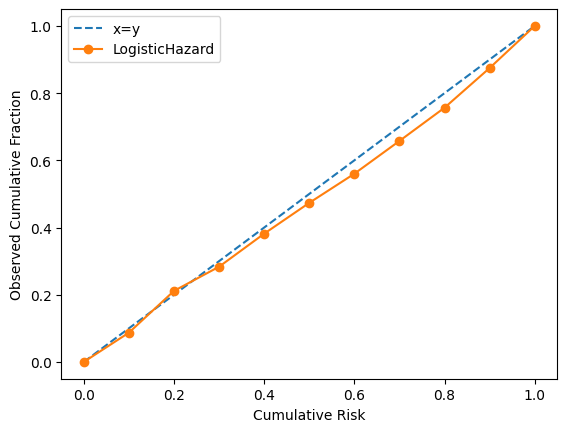

In [20]:
default = np.linspace(0, 1, 11)
plt.plot(default, default, linestyle='dashed', label="x=y")

fraction = np.concatenate((np.array([0]), bin_statistics))
plt.plot(default, fraction.cumsum(), 'o-', label="LogisticHazard")

plt.xlabel("Cumulative Risk")
plt.ylabel("Observed Cumulative Fraction")
plt.legend()
plt.show()